In [1]:
import librosa as lb
import os
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

from glob import glob
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD, Nadam
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Conv1D, Conv2D, MaxPool1D, Flatten, LSTM, MaxPool2D, ConvLSTM2D, GRU, BatchNormalization
from librosa import load
from librosa.feature import mfcc
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
DEFAULT_BITRATE = 22050
DESIRED_DURATION = 25
PADDED_LENGTH = DEFAULT_BITRATE * DESIRED_DURATION
NUM_MFCCS = 50

In [3]:
def load_audio(folder):
    # load original mp3s
    loaded_mp3_files = [load(f) for f in glob(folder + '*.mp3')[:160]]
    
    # make same length
    fix_length_mp3 = normalize_audio(loaded_mp3_files)
    
    mfccs = [mfcc(y=y, sr=DEFAULT_BITRATE, n_mfcc=NUM_MFCCS) for y in fix_length_mp3]
    return mfccs

In [4]:
def normalize_audio(source_files):
    fixed_lengths = [lb.util.fix_length(y, PADDED_LENGTH) for y, _ in source_files]
    return [(f - np.mean(f)) / np.std(f) for f in fixed_lengths]

In [5]:
# def flatten_input(input):
#     return np.array([x.reshape(x.shape[0] * x.shape[1]) for x in input])

In [6]:
english_X = load_audio('../data/speech-accent-archive/recordings/english/')
spanish_X = load_audio('../data/speech-accent-archive/recordings/spanish/')
arabic_X = load_audio('../data/speech-accent-archive/recordings/arabic/')
mandarin_X = load_audio('../data/speech-accent-archive/recordings/mandarin/')
french_X = load_audio('../data/speech-accent-archive/recordings/french/')

In [7]:
print(len(english_X))
english_X[0].shape
# flattened_us_X = flatten_input(us_X)
# flattened_uk_X = flatten_input(uk_X)
# flattened_hk_X = flatten_input(hk_X)
# flattened_cn_X = flatten_input(cn_X)
# flattened_ger_X = flatten_input(ger_X)

160


(50, 1077)

In [8]:
X = np.concatenate([english_X, spanish_X, arabic_X, mandarin_X, french_X])
Y = np.zeros(len(english_X) + len(spanish_X) + len(arabic_X) + len(mandarin_X) + len(french_X))
Y[21:40] = 1
Y[41:60] = 2
Y[61:80] = 3
Y[81:100] = 4

In [9]:
Y_categorical = to_categorical(Y)
print(X.shape)
print(Y_categorical.shape)

(550, 50, 1077)
(550, 5)


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_categorical, test_size=0.09, random_state=1337)

In [39]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(500, 50, 1077)
(500, 5)
(50, 50, 1077)
(50, 5)


In [24]:
def ff_model(X_train, y_train, X_test, y_test):
    print(X_train.shape)
    print(X_test.shape)
    
    X_val = X_train[:30]
    y_val = y_train[:30]
    X_train_true = X_train[30:]
    y_train_true = y_train[30:]
    
    model = Sequential()
    model.add(Dense(2048, activation='relu', input_shape=(53850,)))
    model.add(Dropout(0.3))
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer=Adam(lr=0.000001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(x=X_train_true, y=y_train_true, epochs=16, validation_data=(X_val, y_val),
             callbacks=[EarlyStopping(monitor='val_loss', patience=2)], shuffle=True)
    
    loss, accuracy = model.evaluate(X_test, y_test)
    print('Test loss: %s' % loss)
    print('Test accuracy: %s' % accuracy)
    
    return model, history

In [25]:
ffmodel, ffhistory = ff_model(X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2]), 
                              y_train, 
                              X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2]), 
                              y_test)

(522, 53850)
(28, 53850)
Train on 492 samples, validate on 30 samples
Epoch 1/16
128/492 [======>.......................] - ETA: 1:36 - loss: 9.0895 - acc: 0.3438

KeyboardInterrupt: 

In [12]:
def plot_train_val_acc(history):
    # Plot train-val accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.show()

In [13]:
def plot_train_val_loss(history):
    # Plot tran-val loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.show()

In [ ]:
plot_train_val_acc(ffhistory)
plot_train_val_loss(ffhistory)

In [ ]:
def cnn_model(X_train, y_train, X_test, y_test):
    X_val = X_train[:20]
    y_val = y_train[:20]
    X_train_true = X_train[20:]
    y_train_true = y_train[20:]
    
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(32, 1077, 1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D())
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D())
    model.add(Dropout(0.3))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D())
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(x=X_train_true, y=y_train_true, epochs=16, validation_data=(X_val, y_val), 
              callbacks=[EarlyStopping(monitor='val_loss', patience=2)], shuffle=True)
    
    loss, accuracy = model.evaluate(X_test, y_test)
    print('Test loss: %s' % loss)
    print('Test accuracy: %s' % accuracy)
    
    return model, history

In [ ]:
print(X_train.shape)
print(X_test.shape)

In [ ]:
cnnmodel, cnnhistory = cnn_model(X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1), 
                      y_train, 
                      X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1), 
                      y_test)

In [ ]:
plot_train_val_acc(cnnhistory)
plot_train_val_loss(cnnhistory)

In [45]:
def rnn_model(X_train, y_train, X_test, y_test):
    X_val = X_train[-50:]
    y_val = y_train[-50:]
    X_train_true = X_train[:-50]
    y_train_true = y_train[:-50]
    
    print(X_train.shape)
    print(X_train_true.shape)
    print(X_val.shape)
    
    model = Sequential()
    model.add(LSTM(128, input_shape=(50, 1077), recurrent_dropout=0.7, return_sequences=True, kernel_regularizer=l2(0.001)))
    model.add(LSTM(256, recurrent_dropout=0.7, return_sequences=True, kernel_regularizer=l2(0.001)))
    model.add(LSTM(512, recurrent_dropout=0.7, kernel_regularizer=l2(0.001)))
    model.add(Dense(2048, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.6))
    model.add(Dense(2048, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.6))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(x=X_train_true, y=y_train_true, batch_size=512, epochs=256, validation_data=(X_val, y_val), 
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3)], shuffle=True)
    
    loss, accuracy = model.evaluate(X_test, y_test)
    print('Test loss: %s' % loss)
    print('Test accuracy: %s' % accuracy)
    
    return model, history

In [46]:
rnnmodel, rnnhistory = rnn_model(X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2]), 
                      y_train, 
                      X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2]), 
                      y_test)

(500, 50, 1077)
(450, 50, 1077)
(50, 50, 1077)
Train on 450 samples, validate on 50 samples
Epoch 1/256
450/450 [==============================] - 20s 45ms/step - loss: 5.8619 - acc: 0.1378 - val_loss: 5.3737 - val_acc: 0.8000
Epoch 2/256
450/450 [==============================] - 13s 28ms/step - loss: 5.3217 - acc: 0.8644 - val_loss: 4.7599 - val_acc: 0.8000
Epoch 3/256
450/450 [==============================] - 11s 25ms/step - loss: 4.6283 - acc: 0.8644 - val_loss: 5.6095 - val_acc: 0.8000
Epoch 4/256
450/450 [==============================] - 12s 26ms/step - loss: 5.0699 - acc: 0.8644 - val_loss: 4.5104 - val_acc: 0.8000
Epoch 5/256
450/450 [==============================] - 12s 26ms/step - loss: 4.2050 - acc: 0.8644 - val_loss: 4.3506 - val_acc: 0.8000
Epoch 6/256
450/450 [==============================] - 12s 26ms/step - loss: 4.0864 - acc: 0.8644 - val_loss: 4.2371 - val_acc: 0.8000
Epoch 7/256
450/450 [==============================] - 12s 26ms/step - loss: 3.9457 - acc: 0.8644 

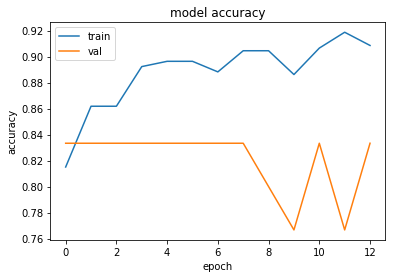

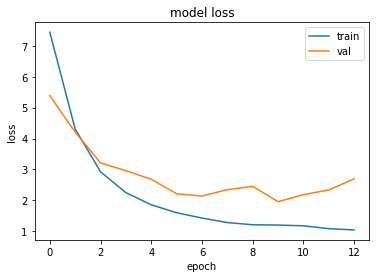

In [18]:
plot_train_val_acc(rnnhistory)
plot_train_val_loss(rnnhistory)